# MaxEnt Sanity Test

This notebook builds a tiny, deterministic test case so the correct result is obvious:
- Two continuous variables `X` and `Y` on [0, 1].
- A single constraint: P(X <= 0.5) = 1.0 (all mass must lie at or below 0.5).

We then build the maximum-entropy distribution and verify that the marginal for `X` places essentially all mass on bins with centers <= 0.5, while `Y` remains unconstrained (approximately uniform).

In [1]:
%load_ext autoreload
%autoreload 2

# Imports and models
from calibrated_response.models.variable import ContinuousVariable
from calibrated_response.models.query import (InequalityProposition, ProbabilityEstimate, 
                                              ConditionalProbabilityEstimate, ExpectationEstimate)
from calibrated_response.maxent.distribution_builder import DistributionBuilder
from calibrated_response.maxent.multivariate_solver import JAXSolverConfig
import numpy as np

In [8]:
# Define two simple continuous variables on [0, 1]--no LLM needed for the test
X = ContinuousVariable(name="X", description="Test variable X", lower_bound=0.0, upper_bound=1.0, unit='a')
Y = ContinuousVariable(name="Y", description="Unconstrained variable Y", lower_bound=0.0, upper_bound=1.0, unit='b')
variables = [X, Y]

prop = InequalityProposition(variable="X", threshold=0.3, is_lower_bound=False)
est = ProbabilityEstimate(id="p_x_le_0_9", proposition=prop, probability=0.8)

xprop = InequalityProposition(variable="X", threshold=0.5, is_lower_bound=True)
prop = InequalityProposition(variable="Y", threshold=0.75, is_lower_bound=True)
est2 = ConditionalProbabilityEstimate(id='ygx', proposition=prop, conditions=[xprop], probability=0.9)

#set expected value of Y to 0.5 to test regularization
est3 = ExpectationEstimate(id='e_y', variable='Y', expected_value=0.8)

estimates = [est, est2, est3]

print('Variables and constraint created:')
print(' -', X.name, X.get_domain())
print(' -', Y.name, Y.get_domain())

# Configure and run the solver (small maxiter for a fast test)
config = JAXSolverConfig(max_bins=10, maxiter=300, tolerance=1e-6, 
                         constraint_weight=1e2, regularization_type='kl_gaussian', 
                         smoothness_weight=1e1)
builder = DistributionBuilder(variables=variables, estimates=estimates, solver_config=config)

print(f'Built {len(builder.constraints)} constraint(s) from estimates')

# Build distribution and request the marginal for X (target variable)
distribution, info = builder.build(target_variable="X")

print('Build finished. Keys in info:', list(info.keys()))

Variables and constraint created:
 - X (0.0, 1.0)
 - Y (0.0, 1.0)
Built 3 constraint(s) from estimates
Build finished. Keys in info: ['n_iterations', 'final_loss', 'entropy', 'converged', 'error', 'state', 'constraint_satisfaction', 'joint_distribution', 'bin_edges_list', 'bin_edges_list_normalized', 'target_variable', 'n_constraints', 'n_estimates', 'domains']


In [9]:
# Check X marginal: all mass should lie at or below 0.5
bin_edges = np.array(distribution.bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
probs = np.array(distribution.bin_probabilities)
mass_left = probs[bin_centers <= 0.5].sum()
print(f'Mass on bins with center <= 0.5: {mass_left:.6f}')

# Expect mass_left very close to 1.0
if mass_left < 0.99:
    print('WARNING: X marginal does not place expected mass <= 0.5 (check solver).')
else:
    print('SUCCESS: X marginal places essentially all mass on <= 0.5 bins.')

# Check Y marginal (unconstrained) -- should be roughly uniform across bins
all_marginals = builder.get_all_marginals(info)
Y_dist = all_marginals['Y']
y_probs = np.array(Y_dist.bin_probabilities)
print(f'Y marginal: min={y_probs.min():.4f}, max={y_probs.max():.4f}, mean={y_probs.mean():.4f}')


Mass on bins with center <= 0.5: 0.924644
Y marginal: min=0.0000, max=0.2363, mean=0.1000


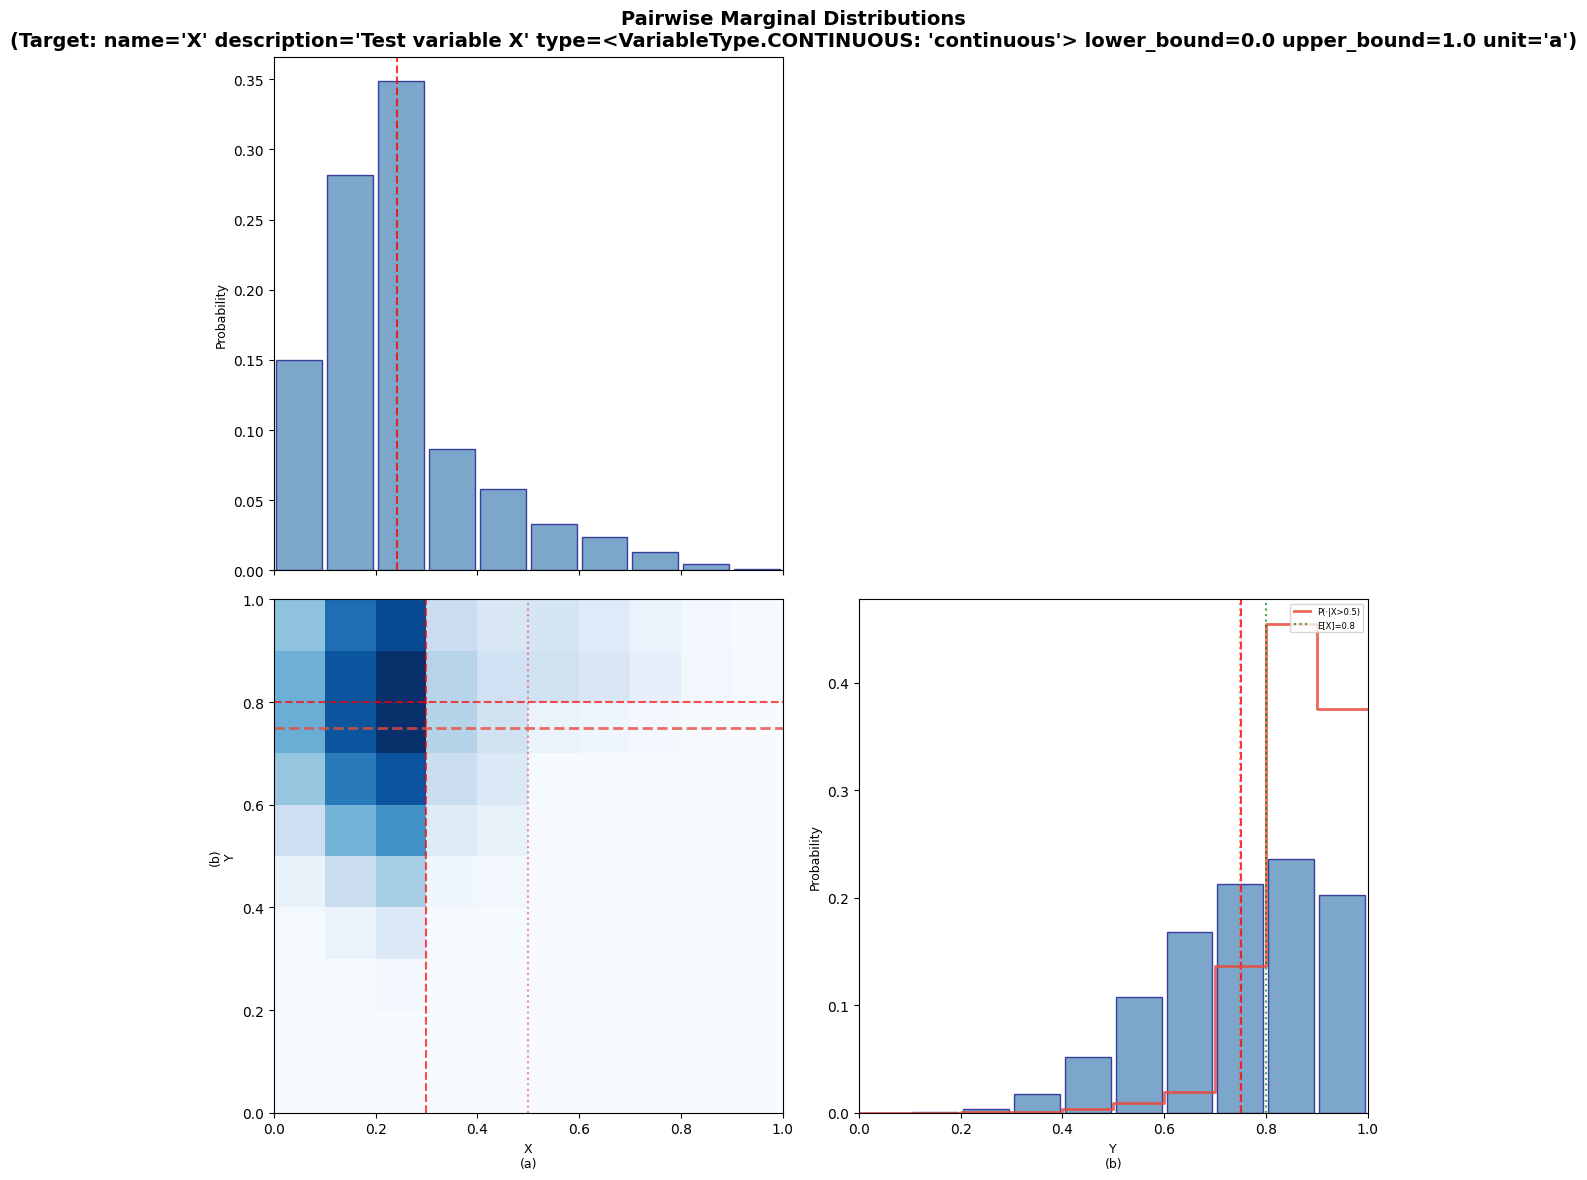

In [10]:
from calibrated_response.visualization.pairplot import plot_pairwise_marginals
import matplotlib.pyplot as plt

# Get the joint distribution and bin edges from the last build
joint_dist = info['joint_distribution']
bin_edges = info['bin_edges_list']

# Create the pairwise plot
fig = plot_pairwise_marginals(
    joint_distribution=joint_dist,
    bin_edges_list=bin_edges,
    variables=variables,
    target_variable=variables[0],
    constraints=builder.constraints,
    figsize=(12, 12),
    cmap='Blues',
)

plt.show()

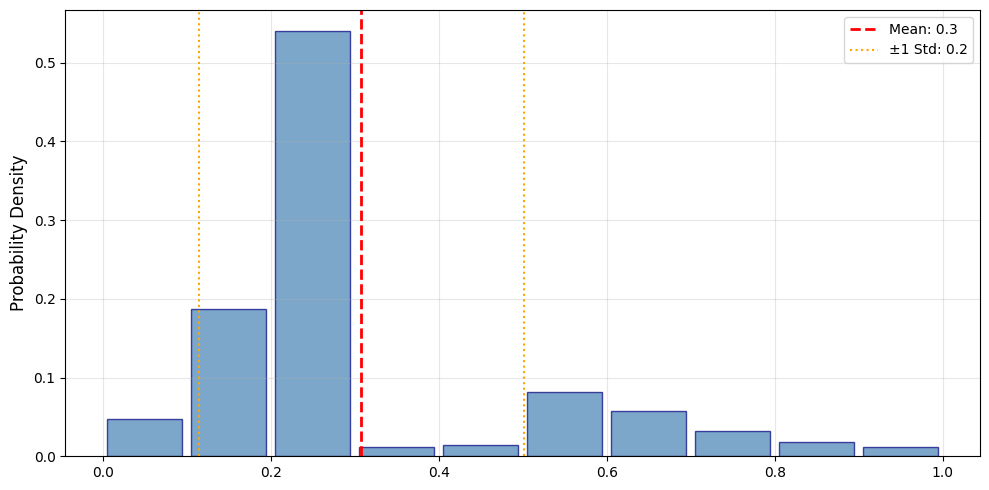


Statistics:
  Mean: 0.31
  Std Dev: 0.19
  90% CI: [-0.01, 0.63]


In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Plot the distribution
fig, ax = plt.subplots(figsize=(10, 5))

bin_edges = np.array(distribution.bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]
probs = np.array(distribution.bin_probabilities)

ax.bar(bin_centers, probs, width=bin_widths * 0.9, alpha=0.7, color='steelblue', edgecolor='navy')
# ax.set_xlabel(f"{target_var.name} ({getattr(target_var, 'unit', '')})", fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
# ax.set_title(f'Maximum Entropy Distribution for {target_var.name}', fontsize=14)
ax.grid(True, alpha=0.3)

# Add statistics
mean = np.sum(probs * bin_centers)
variance = np.sum(probs * (bin_centers - mean) ** 2)
std = np.sqrt(variance)

ax.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f}')
ax.axvline(mean - std, color='orange', linestyle=':', linewidth=1.5, label=f'±1 Std: {std:.1f}')
ax.axvline(mean + std, color='orange', linestyle=':', linewidth=1.5)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nStatistics:")
print(f"  Mean: {mean:.2f}")
print(f"  Std Dev: {std:.2f}")
print(f"  90% CI: [{mean - 1.645*std:.2f}, {mean + 1.645*std:.2f}]")